# Try out CNN on EEG data with labels

## Pre-processing
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.

## Train CNN network
+ Define network architecture
+ Split data
+ Train model


## Import packages & links

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
#%matplotlib inline

from mayavi import mlab

In [2]:
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_ePodium\\"
PATH_CODE = ROOT + "EEG_explorer\\"
PATH_DATA = ROOT + "Data\\"
PATH_OUTPUT = ROOT + "Data\\processed\\"
PATH_METADATA = ROOT + "Data\\metadata\\"
PATH_MODELS = ROOT + "trained_models\\"
file_labels = "metadata.xlsx"

import sys
sys.path.insert(0, PATH_CODE)

## Load pre-processed dataset
+ See notebook for preprocessing: Exploring_EEG_data_04_prepare_data_for_ML.ipynb

In [3]:
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected.npy"
signal_collection = np.load(filename)

filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_labels.npy"
label_collection = np.load(filename)

In [4]:
import csv
metadata = []
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_metadata.csv"
with open(filename, 'r') as readFile:
    reader = csv.reader(readFile, delimiter=',')
    for row in reader:
        if len(row) > 0:
            metadata.append(row)
readFile.close()

In [5]:
metadata[:10]

[['1', '034_17_mc_mmn36_wk.cnt', '443'],
 ['2', '036_17_mc_mmn36_wk.cnt', '1384'],
 ['18', '175_17_jd_mmn_wk.cnt', '1858'],
 ['26', '305_17_jc_mmn36_wk.cnt', '2349'],
 ['27', '306_17_mc_mmn36_wk.cnt', '2813'],
 ['28', '307_17_jc_mmn36_wakker.cnt', '3447'],
 ['29', '308_17_jc_mmn36_wk.cnt', '3938'],
 ['30', '309_17_jc_mmn.cnt', '4425'],
 ['33', '314_17_mc_mmn36_wk.cnt', '4917'],
 ['38', '337_17_jc_mmn36_wk.cnt', '5389']]

## Create training data --> Scale/normalize data

In [90]:
min_maxes = []
for ID in range(1,len(metadata)):
    min_maxes.append((signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].min(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].max(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].mean(), 
                     signal_collection[int(metadata[ID-1][2]):int(metadata[ID][2]),:,:].var()))

In [91]:
data_max = np.mean([x[1] for x in min_maxes]) #signal_collection.max()
data_min = np.mean([x[0] for x in min_maxes]) #signal_collection.min()
data_mean = signal_collection.mean()

signal_collection = signal_collection - data_mean
signal_collection = signal_collection / data_max

In [92]:
signal_collection.min(), signal_collection.max()

(-1.9539306399697487, 2.2628056343165652)

## Create training data --> average epochs

In [40]:
n_epochs = 30 # Average over n_epochs epochs

select_label = np.where(label_collection[:int(metadata[0][2])] == 66)[0]

select = np.random.choice(select_label, n_epochs, replace=False)
signal_averaged = np.mean(signal_collection[select,:,:], axis=0)

In [28]:
signal_averaged.shape

(30, 501)

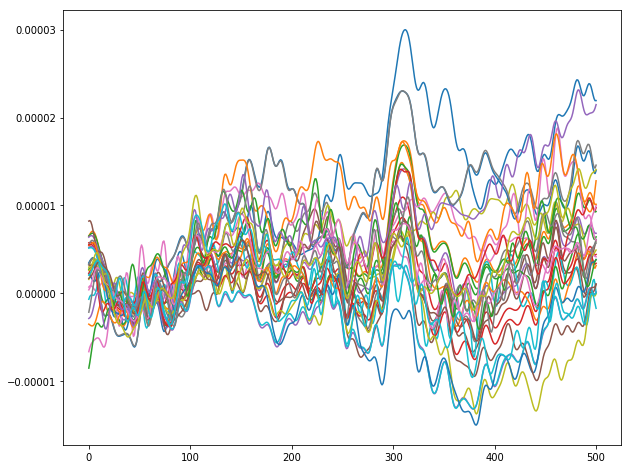

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
for i in range(signal_averaged.shape[0]):
    plt.plot(signal_averaged[i,:])

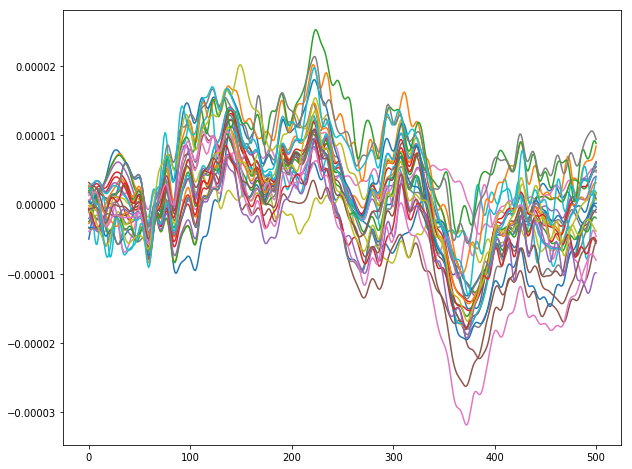

In [41]:
select_label = np.where(label_collection[:int(metadata[0][2])] == 66)[0]

select = np.random.choice(select_label, n_epochs, replace=False)
signal_averaged = np.mean(signal_collection[select,:,:], axis=0)

fig, ax = plt.subplots(figsize=(10,8))
for i in range(signal_averaged.shape[0]):
    plt.plot(signal_averaged[i,:])

In [84]:
n_epochs = 30 # Average over n_epochs epochs
n_class3_per_patient = 20
n_class13_per_patient = 10
n_class66_per_patient = 10

# create new data collection:
X_data = np.zeros((0, signal_collection.shape[1], signal_collection.shape[2]))
y_data = []

for ID in range(len(metadata)):
    print("person number ", ID)
    if ID == 0:
        low = 0
    else:
        low = int(metadata[ID-1][2])
    high = int(metadata[ID][2])
    
    # Create class=3 averages (n_class3_per_patient times)
    for i in range(n_class3_per_patient):      
        select_label = np.where(label_collection[low:high] == 3)[0]
        if len(select_label) == 0:
            select_label = np.where(label_collection[low:high] == 6)[0]
            group = 2
        else:
            group = 1
        if len(select_label) >= n_epochs:        
            select = np.random.choice(select_label, n_epochs, replace=False)
        else:
            print("Found only", len(select_label), " epochs and will take those!")
            signal_averaged = np.mean(signal_collection[select_label,:,:], axis=0)
            break
        signal_averaged = np.mean(signal_collection[select,:,:], axis=0)
        X_data = np.concatenate([X_data, np.expand_dims(signal_averaged, axis=0)], axis=0)
        y_data.append(group*3)
        
     # Create class=13 averages (n_class13_per_patient times)
    for i in range(n_class13_per_patient):      
        select_label = np.where(label_collection[low:high] == 13)[0]
        if len(select_label) == 0:
            select_label = np.where(label_collection[low:high] == 26)[0]
            group = 2
        else:
            group = 1
        if len(select_label) >= n_epochs:        
            select = np.random.choice(select_label, n_epochs, replace=False)
        else:
            print("Found only", len(select_label), " epochs and will take those!")
            signal_averaged = np.mean(signal_collection[select_label,:,:], axis=0)
            break
        signal_averaged = np.mean(signal_collection[select,:,:], axis=0)
        X_data = np.concatenate([X_data, np.expand_dims(signal_averaged, axis=0)], axis=0)
        y_data.append(group*13)
        
    # Create class=66 averages (n_class66_per_patient times)
    for i in range(n_class66_per_patient):      
        select_label = np.where(label_collection[low:high] == 66)[0]
        if len(select_label) == 0:
            select_label = np.where(label_collection[low:high] == 132)[0]
            group = 2
        else:
            group = 1
        if len(select_label) >= n_epochs:        
            select = np.random.choice(select_label, n_epochs, replace=False)
        else:
            print("Found only", len(select_label), " epochs and will take those!")
            signal_averaged = np.mean(signal_collection[select_label,:,:], axis=0)
            break
        signal_averaged = np.mean(signal_collection[select,:,:], axis=0)
        X_data = np.concatenate([X_data, np.expand_dims(signal_averaged, axis=0)], axis=0)
        y_data.append(group*66)

person number  0
person number  1
person number  2
person number  3
person number  4
person number  5
person number  6
person number  7
person number  8
person number  9
person number  10
person number  11
person number  12
person number  13
person number  14
person number  15
person number  16
person number  17
person number  18
person number  19
person number  20
Found only 27  epochs and will take those!
person number  21
person number  22
person number  23
person number  24
person number  25
person number  26
person number  27
person number  28
person number  29
person number  30
person number  31
person number  32
person number  33
person number  34
person number  35
person number  36
person number  37
person number  38
person number  39
person number  40
person number  41
Found only 21  epochs and will take those!
Found only 21  epochs and will take those!
person number  42
person number  43
person number  44
person number  45
person number  46
person number  47
person number  48

In [89]:
print(X_data.shape, len(y_data))
print(y_data[:100])

(2250, 30, 501) 2250
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [97]:
X_data = X_data - X_data.mean()
X_data = X_data / X_data.max()

In [100]:
X_data.mean(), X_data.max(),X_data.min()

(-1.7316084578970325e-17, 1.0, -1.0107684669525416)

## Split training data
The entire dataset is split into:
+ training data (here: about 70%) which is used to train a model.
+ validation data, used to monitor the model progress and avoid overfitting.
+ testing data, meant for final check on model performance.

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [102]:
print('Train set size:', X_train.shape[0])
print('Validation set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])
print()
print("X_train mean, min, max: ", np.mean(X_train), np.min(X_train), np.max(X_train))

Train set size: 1625
Validation set size: 287
Test set size: 338

X_train mean, min, max:  1.3830001996496148e-05 -1.0107684669525416 0.9662922163493366


Label: 26


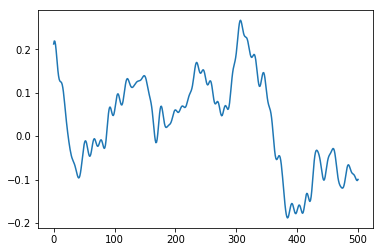

In [110]:
ID = 3
plt.plot(X_train[ID,0,:])
print("Label:", y_train[ID])

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 

In [114]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train_binary = label_transform.fit_transform(np.array(y_train).astype(int))
y_val_binary = label_transform.fit_transform(np.array(y_val).astype(int))
y_test_binary = label_transform.fit_transform(np.array(y_test).astype(int))

In [115]:
y_val_binary[:10,:]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [116]:
# Show found labels:
label_transform.classes_

array([  3,   6,  13,  26,  66, 132])

Check distribution accross the 6 label categories:

In [117]:
labels = list(label_transform.classes_)
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
3,0.209846
6,0.292923
13,0.108308
26,0.142154
66,0.103385
132,0.143385


### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [118]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [119]:
class_weight

array([0.79423265, 0.56897759, 1.53882576, 1.17243867, 1.61210317,
       1.16237482])

In [121]:
class_weight = {0: class_weight[0],
               1: class_weight[1],
               2: class_weight[2],
               3: class_weight[3],
               4: class_weight[4],
               5: class_weight[5]}

## Define model architecture

In [122]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [123]:
np.swapaxes(X_train,1,2)[:2000,:,:].shape

(1625, 501, 30)

In [136]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [137]:
# Model test 1

n_timesteps = 501
n_features = 30
n_outputs = 6

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 493, 64)           17344     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 246, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 240, 64)           28736     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 120, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 116, 128)          41088     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 58, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 56, 128)           49280     
__________

In [138]:
epochs = 50
batch_size = 32
#verbose = 2

# fit network
model.fit(np.swapaxes(X_train,1,2), 
          y_train_binary, 
          validation_data=(np.swapaxes(X_val,1,2), y_val_binary), 
          epochs=epochs, 
          batch_size=batch_size,
          class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 1625 samples, validate on 287 samples
Epoch 1/50
1625/1625 [==============================] - 8s 5ms/step - loss: 1.4135 - acc: 0.2825 - val_loss: 1.6609 - val_acc: 0.2927

Epoch 00001: val_acc improved from -inf to 0.29268, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier.hdf5
Epoch 2/50
1625/1625 [==============================] - 9s 5ms/step - loss: 1.1800 - acc: 0.3594 - val_loss: 1.2901 - val_acc: 0.4216

Epoch 00002: val_acc improved from 0.29268 to 0.42160, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier.hdf5
Epoch 3/50
1625/1625 [==============================] - 9s 6ms/step - loss: 1.0506 - acc: 0.3975 - val_loss: 1.3440 - val_acc: 0.3902

Epoch 00003: val_acc did not improve from 0.42160
Epoch 4/50
1625/1625 [==============================] - 9s 6ms/step - loss: 0.9640 - acc: 0.4400 - val_loss: 1.1192 - val_acc: 0.4878

Epoch 00004: val_acc improved 

## Maybe working...

In [141]:
# evaluate the model
#_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(np.swapaxes(X_test,1,2), y_test_binary, verbose=0)

In [142]:
print(test_acc)

0.46745562147812025


In [143]:
Xtest = np.swapaxes(X_test,1,2)

# check model predictions:
y_pred_proba = model.predict_proba(Xtest)
y_pred_classes = model.predict_classes(Xtest)

In [145]:
y_test_05 = np.array(y_test.copy())
y_test_05[y_test_05 == 132] = 5
y_test_05[y_test_05 == 66] = 4
y_test_05[y_test_05 == 26] = 3
y_test_05[y_test_05 == 13] = 2
y_test_05[y_test_05 == 6] = 1
y_test_05[y_test_05 == 3] = 0

print(y_test_05[:20].astype(int))
print(y_pred_classes[:20])

[1 5 0 0 0 1 0 0 5 0 5 0 5 1 0 2 5 0 0 5]
[1 5 1 3 0 0 1 1 5 2 5 3 5 1 3 2 4 4 0 3]


In [148]:
y_test_12 = np.array(y_test.copy())
y_test_12[y_test_12 == 132] = 2
y_test_12[y_test_12 == 66] = 1
y_test_12[y_test_12 == 26] = 2
y_test_12[y_test_12 == 13] = 1
y_test_12[y_test_12 == 6] = 2
y_test_12[y_test_12 == 3] = 1

y_pred_12 = y_pred_classes.copy()
y_pred_12[y_pred_12 == 5] = 2
y_pred_12[y_pred_12 == 4] = 1
y_pred_12[y_pred_12 == 3] = 2
y_pred_12[y_pred_12 == 2] = 1
y_pred_12[y_pred_12 == 1] = 2
y_pred_12[y_pred_12 == 0] = 1

print(y_test_12[:30].astype(int))
print(y_pred_12[:30])

[2 2 1 2 1 2 1 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 1 2 2 2 1 2 2 1]
[2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 1 1]


In [45]:
np.max(y_test_05)

5.0

In [41]:
# Calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test_05, y_pred_classes))

0.10131332082551595


In [46]:
# Confusion matrix:
M_confusion = metrics.confusion_matrix(y_test_05, y_pred_classes)
M_confusion

array([[ 185,  164,  305,  494,  346,  735],
       [  42,  147,   92,  995,  131, 1379],
       [  27,   21,   41,   49,   44,   63],
       [   0,    0,    0,    0,    0,    0],
       [  28,   19,   33,   55,   34,   68],
       [   4,   21,   10,  132,   12,  187]], dtype=int64)

# TO be continued...
+ Try with only 1 binary label --> Risk group vs Not-risk group
+ Test LSTM
+ Work with higher compression --> more pooling in the beginning ?

# 2. Reduce categories:
One problem might arise from that fact that we don't know the stimuli!  
Very likely either "13 or "66" means that same as "3" and hence CANNOT be distinguishes by the model...  
Here I would like to explore a bit what happens if we only look at 2 categories instead of 6.

## Switch to 1-hot encoding for labels
+ We have six categories or classes. Those are best represented by a so called 1-hot encoding. This means nothing else than simply a binary 0-or-1 for every class.. 

In [83]:
y_test[:100]

array([  3.,   3.,   3.,   6.,  26.,   6.,  66.,   6.,   6.,   3.,   3.,
         6.,   3.,   6.,   6.,   6.,  26.,   3.,   6.,   6.,   6.,   6.,
         6.,   3.,   3.,  66.,   3.,   6.,  66.,   3.,   6.,  66.,  13.,
         6.,   3.,   6.,   6., 132.,   3.,   6.,   3.,  26.,   3., 132.,
         3.,   3.,  66.,   3.,   3.,   3.,   6.,   6.,   6.,   6.,   6.,
         3.,  66.,   3.,   3.,   6.,   6.,   6.,   3.,   3.,   3.,   3.,
         6.,   3.,   6.,   6.,   3.,   3.,  66.,   3.,   6.,   6., 132.,
        66.,   6.,   6.,   3.,   3.,   3.,   6.,  66., 132.,   6.,   3.,
         3.,   6.,   3.,   6.,   6.,   3.,   6.,   6.,  66.,  13.,   3.,
         3.])

In [50]:
# only pick two categories! -> here: 3 and 6
select = np.where((y_train == 3 ) | (y_train == 6 )) 
y_train2 = y_train[select]
X_train2 = X_train[select]

select = np.where((y_val == 3 ) | (y_val == 6 )) 
y_val2 = y_val[select]
X_val2 = X_val[select]

select = np.where((y_test == 3 ) | (y_test == 6 )) 
y_test2 = y_test[select]
X_test2 = X_test[select]

In [81]:
select[0][:10]

array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11], dtype=int64)

In [101]:
X_train.shape, X_train2.shape, y_train.shape, y_train2.shape

((28237, 30, 501), (22636, 30, 501), (28237,), (22636,))

In [52]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train2_binary = label_transform.fit_transform(y_train2.astype(int))
y_val2_binary = label_transform.fit_transform(y_val2.astype(int))
y_test2_binary = label_transform.fit_transform(y_test2.astype(int))

In [105]:
print(y_val2_binary[:40,0])

[0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 1 1 1]


In [54]:
# Show found labels:
label_transform.classes_

array([3, 6])

Check distribution accross the 2 selected label categories:

In [56]:
labels = list(label_transform.classes_)
frequencies = y_train2_binary.mean(axis=0)

frequencies

array([0.60929493])

### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [57]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train2)
                                               ,y_train2)

In [58]:
class_weight

array([1.27973768, 0.82062065])

In [59]:
class_weight = {0: 1.27973768,
               1: 0.82062065}

## Define model architecture

In [118]:
# Model test 2
from keras.layers import BatchNormalization
from keras import optimizers

n_timesteps = 501
n_features = 30
n_outputs = 1

optimizer = optimizers.SGD(lr=0.0001, momentum=0.1, decay=0.1, nesterov=False)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(BatchNormalization())
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
#model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 493, 64)           17344     
_________________________________________________________________
batch_normalization_3 (Batch (None, 493, 64)           256       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 246, 64)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 240, 64)           28736     
_________________________________________________________________
batch_normalization_4 (Batch (None, 240, 64)           256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 240, 64)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 120, 64)           0         
__________

In [110]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [111]:
np.max(X_train2[0])

0.0812634354474251

In [119]:
epochs = 10
batch_size = 32

# fit network
model.fit(1*np.swapaxes(X_train2,1,2), y_train2_binary, 
          validation_data = (1*np.swapaxes(X_val2,1,2), y_val2_binary), 
          epochs = epochs, 
          batch_size = batch_size,
          #class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 22636 samples, validate on 3961 samples
Epoch 1/10
22636/22636 [==============================] - 212s 9ms/step - loss: 6.2288 - acc: 0.6093 - val_loss: 6.2989 - val_acc: 0.6049

Epoch 00001: val_acc did not improve from 0.60490
Epoch 2/10
22636/22636 [==============================] - 192s 8ms/step - loss: 6.2288 - acc: 0.6093 - val_loss: 6.2989 - val_acc: 0.6049

Epoch 00002: val_acc did not improve from 0.60490
Epoch 3/10
16736/22636 [=====================>........] - ETA: 45s - loss: 6.2737 - acc: 0.6065

KeyboardInterrupt: 

In [71]:
# evaluate the model
#_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(10*np.swapaxes(X_test2,1,2), y_test2_binary, verbose=0)

In [73]:
print(test_acc)
print(y_test2_binary.mean())

0.5960633290543432
0.5960633290543432


In [74]:
Xtest = 10*np.swapaxes(X_test2,1,2)[:200,:,:]

In [75]:
ytest = model.predict_proba(Xtest)
ytest

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],